# MDF dataset

In [ ]:
import pandas as pd
import numpy as np
import pprint
import os
from tqdm import tqdm
import holidays

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20

## Some functions

In [ ]:
def filter_wifi_scans(folder_path):
    """
    Opens wifi_scans.csv file
    group by time and assign true to a group only if there is at least one row with connected == true
    skips the process if the file wifi_scans2.csv already exists
    """
    if os.path.isfile(folder_path+'/wifi_scans2.csv'):
        # print (f"File {folder_path+'/wifi_scans2.csv'} already exists")
        return
    a = pd.read_csv(folder_path+'/wifi_scans.csv')
    b = a[['time', 'connected']].groupby(['time'], as_index=False).any() # any() returns true if at least one entry is true
    b.to_csv(folder_path+'/wifi_scans2.csv', index=False)

In [ ]:
def get_closest_row(file_path, columns, dt):
    """
    finds the row in a dataframe whose time column is closest to dt

    :file_path: CSV file location on disk
    :columns: columns to read when opening the file
    :dt: time in ms
    :return: closest row as numpy array
    """ 
    df = pd.read_csv(file_path, header=0, usecols=['time']+columns) # read only selected CSV columns + time column
    df['time'] = pd.to_datetime(df['time'], unit='ms') # convert from ms to date
    df.sort_values('time', inplace=True)
    df.drop_duplicates(subset='time', keep="first", inplace=True)
    df.set_index('time', inplace=True)
    closest = df.iloc[[df.index.get_loc(dt, method='nearest')]].values[0] # find nearest row to time dt
    return np.asarray(closest)

## Merge datasets

In [ ]:
# dictionary structured as file : columns
file_dict = {'activities.csv': ['in_vehicle', 'on_bicycle', 'on_foot', 'running', 'still', 'tilting', 'walking', 'unknown'], 
             'audio.csv': ['ringer_mode', 'alarm_volume', 'music_volume', 'notifications_volume', 'ring_volume', 'bt_sco_connected', 
                           'mic_muted', 'music_active', 'speaker_on', 'headset_connected'],
             'battery.csv': ['level', 'charging'],
             'display.csv': ['state', 'rotation'],
             'weather.csv': ['weather_id', 'temp', 'temp_min', 'temp_max', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 
                             'clouds', 'rain_last3h', 'snow_last3h', 'sunrise_time', 'sunset_time'],
             'wifi_scans2.csv': ['connected'],
             'location.csv': ['label', 'place_type']}

In [ ]:
data_path = 'Datasets/MDF/'
# system apps like launcher,package manager, settings, ota...
ignored_apps = """it.cnr.iit.sensapp com.android.systemui com.sec.android.app.launcher com.android.settings com.android.vending
                  com.android.captiveportallogin com.google.android.packageinstaller com.teslacoilsw.launcher com.android.packageinstaller
                  com.samsung.android.MtpApplication com.sec.android.emergencylauncher com.wssyncmldm com.huawei.android.launcher
                  com.huawei.systemmanager com.asus.launcher android com.asus.ime com.asus.dm com.cyanogenmod.trebuchet
                  org.cyanogenmod.resolver com.android.launcher3 com.oneplus.ota com.samsung.android.game.gametools
                  com.samsung.android.app.galaxyfinder com.huawei.gamebox.global com.sec.android.inputmethod com.android.phone 
                  com.samsung.android.scloud com.huawei.android.internal.app com.miui.home com.android.providers.downloads.ui
                  com.android.printspooler com.lge.launcher3 com.lge.phonemanagement com.lge.bluetoothsetting com.lge.wifisettings
                  com.lge.homeselector com.lge.launcher2 com.lge.lockscreensettings it.cnr.iit.contextlabeler
                  com.sec.android.preloadinstaller com.android.server.telecom com.asus.powersaver com.android.stk
                  it.cnr.iit.mymoviedb """.split() 

In [ ]:
for user in range(31): # foreach user folder
    user_dir = data_path + 'user_' + str(user)
    filter_wifi_scans(user_dir)

In [ ]:
df = pd.DataFrame()   
for user in list(range(0,27)) + list(range(28,31)): # foreach user folder, skip user 27 it doesn't works for some reasons
    print(f"working on user {user}...")
    user_dir = data_path + 'user_' + str(user)
    
    df1 = pd.read_csv(user_dir + '/running_apps.csv', header=0) # read running apps dataframe and use it as a starting point
    df1 = df1[~df1['app'].isin(ignored_apps)]  # ignore system apps
    df1 = df1[~df1.app.str.contains("samsung|huawei|lge|asus|xiaomi|cyanogenmod")] # ignore brand apps
    df1 = df1[~df1.category.isnull()]  # ignore apps with NaN category
    df1['time'] = pd.to_datetime(df1['time'], unit='ms') # convert date from ms to datetime
    df1.sort_values('time', inplace=True)
    # df1.drop_duplicates(subset='time', keep="first", inplace=True)
    df1.reset_index(drop=True, inplace=True)
    df1.insert(1,'user',user) # insert user ID column
    
    rows = []
    for dt in tqdm(df1['time']): # foreach row in running apps dataframe find the closest row in all other dataframes using datetime
        row = []
        for filename, columns in file_dict.items(): # foreach csv file in user folder
            file_path = user_dir + '/' + filename
            row = row + get_closest_row(file_path, columns, dt).tolist() # single row with all the context features
        rows.append(row)

    df2 = pd.DataFrame(rows, columns=np.concatenate(list(file_dict.values()))) # from list of list to dataframe
    df3 = pd.concat([df1, df2], axis=1) # concat by column
    df = pd.concat([df, df3], axis=0) # concat by row
    
df.reset_index(drop=True, inplace=True)
print("done!")

In [ ]:
df

## Extract new features

In [ ]:
def daytime_from_date(date):
    hour = date.hour
    if hour >= 5 and hour <= 12:
        return 'morning'
    elif hour >= 13 and hour <= 18:
        return 'afternoon'
    elif hour >= 19 and hour <= 22:
        return 'evening'
    else:
        return 'night'
    
def weekday_from_date(date):
    return date.strftime("%A")

def is_weekend(weekday:str):
    return True if weekday == 'Saturday' or weekday == 'Sunday' else False

it_holidays = holidays.Italy()

def is_holiday(date):
    return date in it_holidays

In [ ]:
df['daytime'] = df['time'].apply(daytime_from_date)
df['weekday'] = df['time'].apply(weekday_from_date)
df['is_weekend'] = df['weekday'].apply(is_weekend)
df['is_holiday'] = df['time'].apply(is_holiday)

df

## Encoding

**place type**: group similar labels under a more general labels (es. food, restaurant and bar under food label)

In [ ]:
df.loc[df['place_type'].isin(['restaurant', 'bar', 'cafe', 'food']), 'place_type'] = 'food_and_drink'
df.loc[df['place_type'].isin(['route', 'street', 'park', 'tourist_attraction']), 'place_type'] = 'outdoors'
df.loc[df['place_type'].isin(['transit_station', 'bus_station', 'taxi_stand']), 'place_type'] = 'public_transport_station'
df.loc[df['place_type'].isin(['supermarket', 'home_goods', 'bakery', 'shopping_mall', 'library', 'book_store', 'florist']), 'place_type'] = 'store'
df.loc[df['place_type'].isin(['health', 'doctor']), 'place_type'] = 'health'
df.loc[df['place_type'].isin(['finance', 'gas_station', 'general_contractor', 'bank', 'premise', 'lawyer', 'insurance_agency', 'hair_care', 'city_hall', 'plumber', 'pharmacy', 'police', 'veterinary', 'laundry', 'place_of_worship', 'university', 'moving_company', 'post_office', 'car_repair', 'real_estate_agency', 'painter', 'car_wash', 'local_government_office', 'beauty_salon', 'electrician', 'car_rental', 'funeral_home', 'fire_station', 'travel_agency']), 'place_type'] = 'service'

**category**: group all GAME subcategories under GAME label

In [ ]:
df.loc[df['category'].str.contains('GAME'), 'category'] = 'GAME'
df.loc[df['category'].isin([' COMMUNICATION']), 'category'] = 'COMMUNICATION' # fix communication category with space at the beginning

## Plots

In [ ]:
df[df.app == 'com.whatsapp']

<AxesSubplot:>

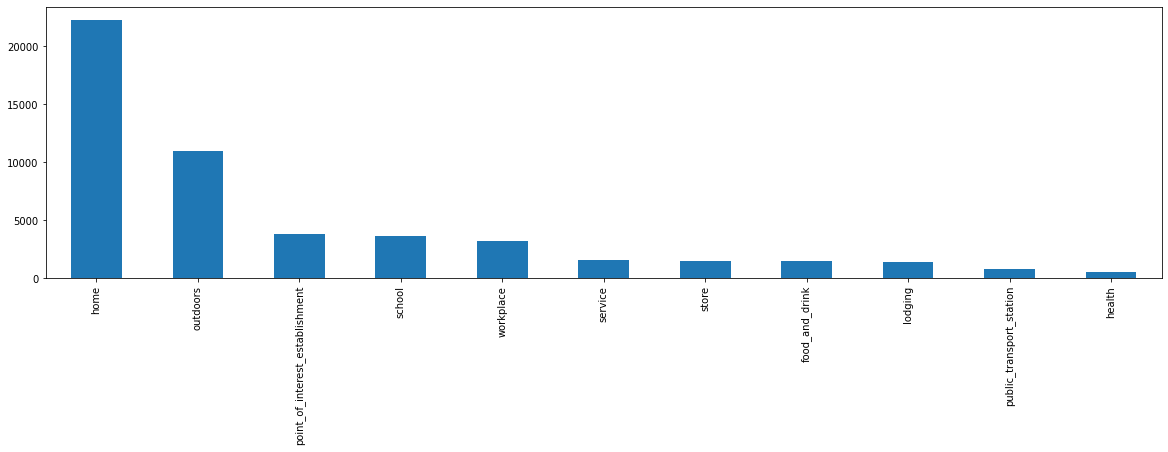

In [40]:
df['place_type'].value_counts().plot.bar(figsize=(20,5))

<AxesSubplot:>

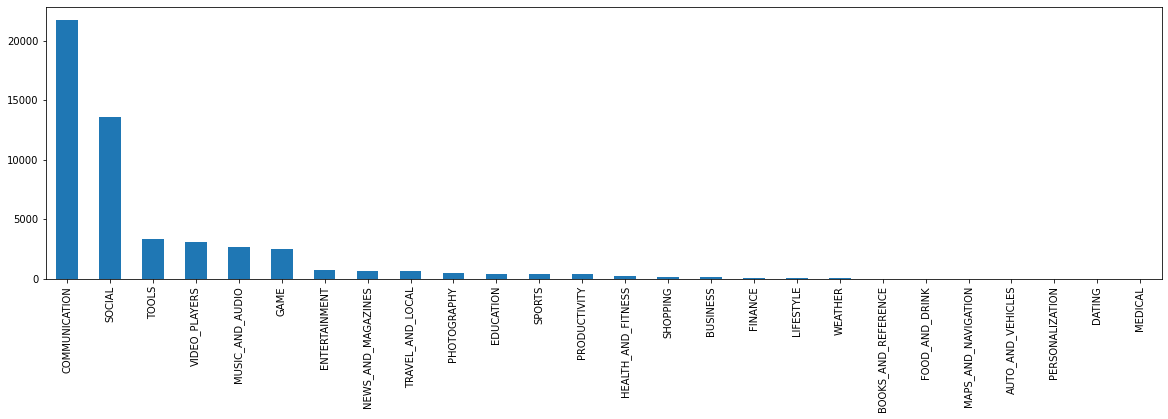

In [41]:
df['category'].value_counts().plot.bar(figsize=(20,5))

<AxesSubplot:>

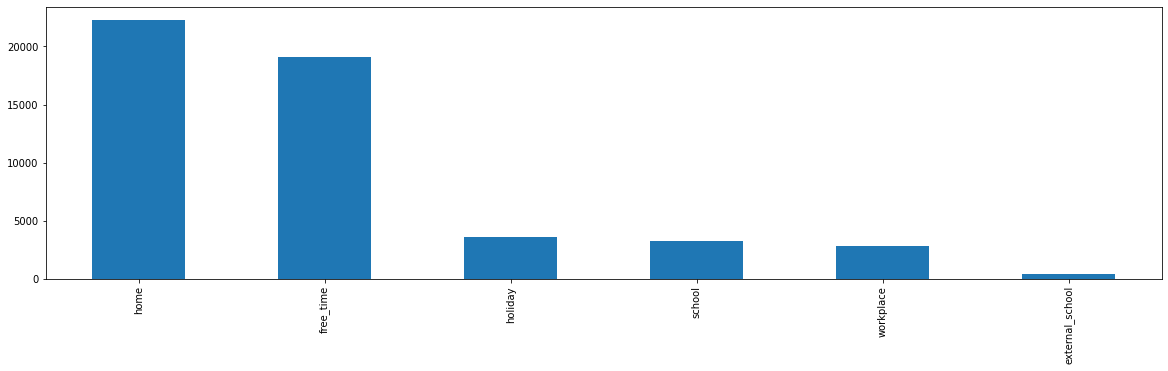

In [42]:
df['label'].value_counts().plot.bar(figsize=(20,5))

## Save to CSV

In [ ]:
df.to_csv('MDF_final.csv', index=False)